Unique labels: ['Surprise' 'Sad' 'Happy' 'Neutral' 'Angry']
Total number of unique labels: 5
Original Paths:
<bound method NDFrame.head of                                                    path     label
0     gs://storage_for_all/DataSets/FacialEmotionRec...   Neutral
1     gs://storage_for_all/DataSets/FacialEmotionRec...       Sad
2     gs://storage_for_all/DataSets/FacialEmotionRec...     Happy
3     gs://storage_for_all/DataSets/FacialEmotionRec...   Neutral
4     gs://storage_for_all/DataSets/FacialEmotionRec...   Neutral
...                                                 ...       ...
4995  gs://storage_for_all/DataSets/FacialEmotionRec...   Neutral
4996  gs://storage_for_all/DataSets/FacialEmotionRec...  Surprise
4997  gs://storage_for_all/DataSets/FacialEmotionRec...     Angry
4998  gs://storage_for_all/DataSets/FacialEmotionRec...   Neutral
4999  gs://storage_for_all/DataSets/FacialEmotionRec...     Angry

[5000 rows x 2 columns]>

Updated Paths:
Image shape: (None, None, 3

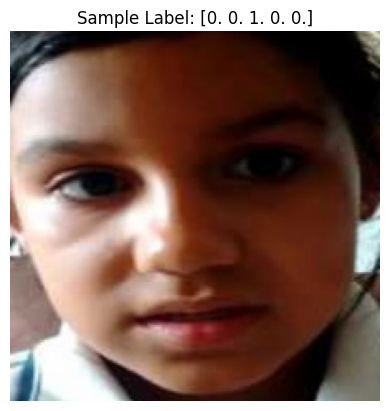

Images batch shape: (16, 224, 224, 3)
Labels batch shape: (16, 5)


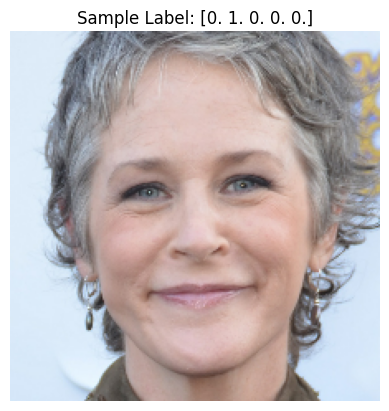

Images batch shape: (16, 224, 224, 3)
Labels batch shape: (16, 5)


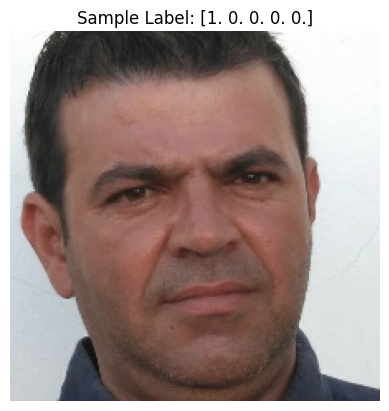

Images batch shape: (16, 224, 224, 3)
Labels batch shape: (16, 5)


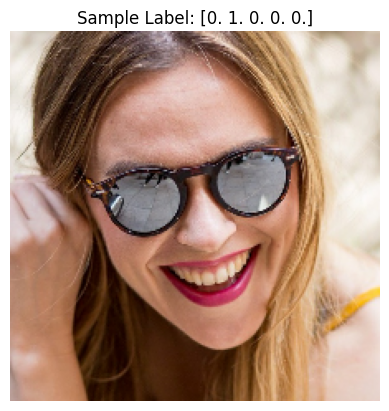

Images batch shape: (16, 224, 224, 3)
Labels batch shape: (16, 5)


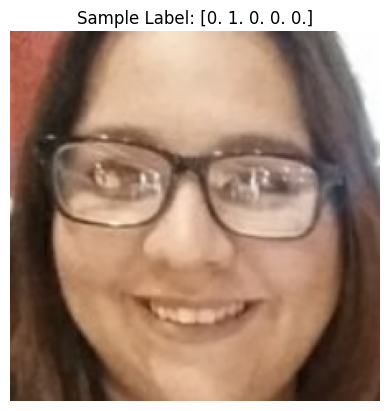

num_classes value is : 5
      3/Unknown - 6s 1s/step - loss: 1748.8121 - accuracy: 0.2292

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import datetime
import time
import psutil
from tensorflow.keras.callbacks import ModelCheckpoint


# Load CSV data
csv_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/data.csv'
df = pd.read_csv(csv_path)
df = df[~df['label'].str.contains('Ahegao')]


# Display the total number of unique labels in the 'label' column
unique_labels = df['label'].unique()
total_unique_labels = len(unique_labels)

print("Unique labels:", unique_labels)
print("Total number of unique labels:", total_unique_labels)

# Print the original paths
print("Original Paths:")
#print(df['path'].head())

df = df.drop(df.columns[0], axis=1)

df = df.sample(n=5000).reset_index(drop=True) # limit number of values and shuffle
#df = df[:100]
#df_head = df.head(100)

# Adjust paths
df['path'] = df['path'].apply(lambda x: f"gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/dataset/{x.split('/')[-2]}/{x.split('/')[-1]}")
#df = df[df['path'].str.endswith('.jpg')]
print(df.head)


# Print the updated paths
print("\nUpdated Paths:")
#print(df['path'].head())


# Label encoding for ML processing
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['label'])
one_hot_encoded_labels = to_categorical(integer_encoded)

# Dataset preparation function
def load_image(file_path, label):
    """Load and preprocess images from file paths, handling different formats based on extensions."""
    try:
        image_data = tf.io.read_file(file_path)
        
        # Conditionally decode based on the file extension
        def decode_jpeg():
            return tf.image.decode_jpeg(image_data, channels=3)
        
        def decode_png():
            return tf.image.decode_png(image_data, channels=3)
        
        # Default to using decode_image which works for most formats but does not return a shape statically
        def decode_fallback():

            image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
            print("Image shape:", image.shape)

            return image
        
        # Check the file extension and decode accordingly
        image = tf.cond(
            tf.strings.regex_full_match(file_path, ".*\.jpeg$|.*\.jpg$"),
            true_fn=decode_jpeg,
            false_fn=lambda: tf.cond(
                tf.strings.regex_full_match(file_path, ".*\.png$"),
                true_fn=decode_png,
                false_fn=decode_fallback
            )
        )
        
        image = tf.image.resize(image, [224, 224])
        return image, label
    except tf.errors.NotFoundError:
        print(f"Failed to load image at: {file_path}")
        return None, label
    except Exception as e:
        print(f"Error processing image at: {file_path}", str(e))
        return None, label
# def load_image(file_path, label):
#     print("in load_image")
#     """Load and preprocess images from file paths."""
#     try:
#         image_data = tf.io.read_file(file_path)
#         if file_path.endswith('.jpeg') or file_path.endswith('.jpg'):
#             image = tf.image.decode_jpeg(image_data, channels=3)
#         elif file_path.endswith('.png'):
#             image = tf.image.decode_png(image_data, channels=3)
#         else:
#             image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
        
#         image = tf.image.resize(image, [224, 224])
# #         image_data = tf.io.read_file(file_path)
# #         image = tf.image.decode_jpeg(image_data, channels=3) # channels is rgb
# #         #image = tf.image.decode_image(image_data, channels=3) # channels is rgb
# #         print("Original image shape:", tf.shape(image))

# #         #image = tf.image.resize(image, [224, 224])  # Resize as needed
# #         print("image is", image.shape)
# #         print("label is", label)
#         return image, label
#     except tf.errors.NotFoundError:
#         print(f"Failed to load image at: {file_path}")
#         return None, label  # Handle missing files gracefully

# Create TensorFlow datasets
full_dataset = tf.data.Dataset.from_tensor_slices((df['path'].tolist(), one_hot_encoded_labels))
# print("full_dataset is :", full_dataset)
# for path, label in full_dataset.as_numpy_iterator():
#     print(path, label)

full_dataset = full_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # This line of code applies the load_image function to each element in the full_dataset using the map method, with the num_parallel_calls argument set to tf.data.experimental.AUTOTUNE


# for image, label in full_dataset.as_numpy_iterator():
#     print("Image Shape:", image.shape)
#     print("Label:", label)
#     print()  # Add a newline for better readability
# for image, label in full_dataset.as_numpy_iterator():
#     print("image shape", image.shape)
#     print("label", label)
    
    
print("past laod_image")
full_dataset = full_dataset.filter(lambda x, y: x is not None and y is not None) #clean dataset with clean data





# print("First few records of the filtered dataset:")
# for i, (x, y) in enumerate(full_dataset.as_numpy_iterator()):
#     print("x (Image):", x)
#     print("x Shape:", x.shape)
#     print("y (Label):", y)
#     print()
#     if i >= 5:  # Print only the first 5 records
#         break


# full_dataset = full_dataset.batch(6).prefetch(tf.data.experimental.AUTOTUNE)
full_dataset = full_dataset.batch(16, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
'''
Batching: full_dataset.batch(32): This transformation groups the dataset into batches of 32 elements each. This means that instead of processing individual elements, the dataset will now be processed in batches of 32 elements.
Prefetching: .prefetch(tf.data.experimental.AUTOTUNE): This transformation prefetches a certain number of batches from the dataset and stores them in memory. By setting tf.data.experimental.AUTOTUNE, TensorFlow will automatically determine the optimal number of batches to prefetch based on the available resources (e.g., CPU, memory).
'''

# Split dataset into training and validation
dataset_size = len(df)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.take(train_size)

print("Total dataset size:", dataset_size)
print("Training dataset size:", train_size)
print("Validation dataset size:", val_size)






# val_dataset = val_dataset.take(val_size)
# train_dataset = full_dataset.take(train_size)







# # Split dataset into training and validation
# dataset_size = len(df)

# train_size = int(0.8 * dataset_size)
# train_dataset = full_dataset.take(train_size)

# for val_size we want to get a random 20% from dataset_size that includdes all num_labels   # Ensure this is not zero




# labels = unique_labels
# val_dataset = val_dataset[val_dataset['label'].isin(labels)]
# val_size = int(0.1 * len(val_dataset))
# val_dataset = val_dataset.take(val_size)
# train_dataset = full_dataset.take(train_size)
# print("Total dataset size:", dataset_size)
# print("Training dataset size:", train_size)
# print("Validation dataset size:", val_size)












# print("Training dataset:")
# for batch in train_dataset.as_numpy_iterator():
#     print("Batch shape:", batch[0].shape)
#     print("Batch labels:", batch[1])
#     print()

# print("Validation dataset:")
# for batch in val_dataset.as_numpy_iterator():
#     print("Batch shape:", batch[0].shape)
#     print("Batch labels:", batch[1])
#     print()





# train_size = int(0.8 * dataset_size)
# val_size = dataset_size - train_size  # Ensure this is not zero

# train_dataset = full_dataset.take(train_size)
# val_dataset = full_dataset.skip(train_size)

# print("Total dataset size:", dataset_size)
# print("Training dataset size:", train_size)
# print("Validation dataset size:", val_size)

# val_batch_count = val_dataset.cardinality().numpy()
# print("Number of batches in validation dataset:", val_batch_count)

# if val_batch_count > 0:
#     for images, labels in val_dataset:
#         print("Images batch shape:", images.shape)
#         print("Labels batch shape:", labels.shape)
#         break  # Break after the first complete batch
# else:
#     print("Validation dataset is empty.")

# print(f"Total dataset size: {dataset_size}")
# print(f"Training dataset size (0.8 * Total): {train_size}")
# print(f"Validation dataset size (Total - Training size): {val_size}")


for images, labels in val_dataset.take(5):  # Take the first batch from the validation dataset
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    # Show the first image and label as an example
    if images.shape[0] > 0:  # Check if there are any images in the batch
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Sample Label: {labels[0].numpy()}")
        plt.axis('off')
        plt.show()



    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

# # Get the first 5 rows of the validation dataset
# val_dataset_subset = val_dataset.take(5)

# # Print the subset
# for batch in val_dataset_subset.as_numpy_iterator():
#     print(batch)

# Model definition
def tf_model(num_classes):
    print("num_classes value is :", num_classes)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

class PerformanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
        self.process = psutil.Process(os.getpid())

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        memory_usage = self.process.memory_info().rss / (1024 ** 2)  # Memory in MB
        print(f"Epoch {epoch+1} ended. Time: {epoch_time:.2f}s, Memory Usage: {memory_usage:.2f} MB")
        if 'val_loss' in logs:
            print(f"Validation Loss: {logs['val_loss']}")

# Define the model name and local path
model_name = f"Emotion_Detection_AI_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_v1.h5"
local_model_path = f"/tmp/{model_name}"

# Create a new directory for models if it doesn't exist
model_name=""
model_dir = "gs://storage_for_all/models"
full_model_path = f"{model_dir}/{model_name}"

num_classes = len(label_encoder.classes_)  # Number of unique classes
model = tf_model(num_classes)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    local_model_path,
    save_weights_only=False,
    save_best_only=False,
    verbose=1  # Logs output whenever the model is saved.
)

# Define a custom callback to copy the model to GCS
class CopyModelToGCS(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Save the model locally
        self.model.save(local_model_path, save_format='h5')

        # Copy the model to Google Cloud Storage
        gcs_model_path = f"gs://storage_for_all/models/{model_name}"
        os.system(f"gsutil cp {local_model_path} {gcs_model_path}")

        # Verify the model was copied
        if tf.io.gfile.exists(gcs_model_path):
            print(f"Model saved successfully to {gcs_model_path}")
        else:
            print("Failed to save the model to GCS")

# Create a list of callbacks
callbacks = [checkpoint_callback, CopyModelToGCS()]

# Train the model with the callbacks
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)


























# # Setup ModelCheckpoint callback
# checkpoint_callback = ModelCheckpoint(
#     local_model_path,
#     save_weights_only=False,
#     save_best_only=False,
#     verbose=1  # Logs output whenever the model is saved.
# )

# # Model training
# history = model.fit(
#     train_dataset,
#     epochs=10,
#     validation_data=val_dataset,
#     callbacks=[checkpoint_callback, PerformanceCallback()],
#     use_multiprocessing=True,
#     workers=3,
#     verbose=1
# )

    

# Model training
# history = model.fit(
#     train_dataset,
#     epochs=10,
#     validation_data=val_dataset,
#     callbacks=[PerformanceCallback()],
#     use_multiprocessing=True,
#     workers=3,
#     verbose=1
# )


# Save the model locally
#model.save(local_model_path, save_format='h5')

# # Model training
# history = model.fit(
#     train_dataset,
#     epochs=10,
#     validation_data=val_dataset,
#     use_multiprocessing=True,
#     workers=3
# )

# Print out the keys and values in history
print("History keys:", list(history.history.keys()))
print("\nDetailed Training History:")

# Iterate through each epoch
for i, values in enumerate(zip(*history.history.values())):
    epoch_data = f"Epoch {i+1}:\n"
    # Iterate over each metric
    for key, value in zip(history.history.keys(), values):
        epoch_data += f"    {key}: {value}\n"
    print(epoch_data)


# Print out the keys and values in history
print("History keys:", history.history.keys())
print("History values:")
for key, values in history.history.items():
    print(f"{key}: {values}")

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)















# Save the model locally
model.save(local_model_path, save_format='h5')

# Copy the model to Google Cloud Storage
gcs_model_path = f"gs://storage_for_all/models/{model_name}"
os.system(f"gsutil cp {local_model_path} {gcs_model_path}")

# Verify the model was copied
if tf.io.gfile.exists(gcs_model_path):
    print(f"Model saved successfully to {gcs_model_path}")
else:
    print("Failed to save the model to GCS")

    
# Define the model name and GCS path
model_name = "Emotion_Detection_AI_20240803_040927_v1.h5"  # Replace with your actual model name
gcs_model_path = f"gs://storage_for_all/models/{model_name}"
local_model_path = f"/tmp/{model_name}"

# Copy the model from GCS to local path
os.system(f"gsutil cp {gcs_model_path} {local_model_path}")



# Verify the model was copied
if not tf.io.gfile.exists(local_model_path):
    print("Failed to load the model from GCS")
else:
    print(f"Model loaded successfully from {gcs_model_path}")

    # Load the model from local path
    model = tf.keras.models.load_model(local_model_path)
    print("Model loaded into TensorFlow")
    try:
        # Evaluate the model on the validation dataset
        loss, accuracy = model.evaluate(val_dataset)

        # Print the evaluation results
        print(f"Test Loss: {loss:.3f}")
        print(f"Test Accuracy: {accuracy:.3f}")

    except Exception as e:
        print(f"Error evaluating model: {e}")
        


    # Function to predict emotion and display the image
    def predict_emotion(image_path):
        image_data = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.expand_dims(image, 0)  # Make batch of 1

        predictions = model.predict(image)
        predicted_class = np.argmax(predictions[0])
        emotion_label = label_encoder.inverse_transform([predicted_class])[0]

        # Display the image with the predicted emotion
        plt.figure(figsize=(4, 4))
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.title(f"Predicted Emotion: {emotion_label}")
        plt.axis('off')
        plt.show()

        return emotion_label

    # Example usage    
    image_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/dataset/Surprise/1bd930d6a1c717c11be33db74823f661cb53f86cbba1d3d1f336cdf9~12fffff.jpg'
    predicted_emotion = predict_emotion(image_path)
    print("Predicted Emotion:", predicted_emotion)
